In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/archive.zip' -d '/content/dataset'

Mounted at /content/drive
Archive:  /content/drive/MyDrive/archive.zip
  inflating: /content/dataset/elpv-dataset-master/LICENSE.md  
  inflating: /content/dataset/elpv-dataset-master/README.md  
  inflating: /content/dataset/elpv-dataset-master/doc/images/overview.jpg  
  inflating: /content/dataset/elpv-dataset-master/images/cell0001.png  
  inflating: /content/dataset/elpv-dataset-master/images/cell0002.png  
  inflating: /content/dataset/elpv-dataset-master/images/cell0003.png  
  inflating: /content/dataset/elpv-dataset-master/images/cell0004.png  
  inflating: /content/dataset/elpv-dataset-master/images/cell0005.png  
  inflating: /content/dataset/elpv-dataset-master/images/cell0006.png  
  inflating: /content/dataset/elpv-dataset-master/images/cell0007.png  
  inflating: /content/dataset/elpv-dataset-master/images/cell0008.png  
  inflating: /content/dataset/elpv-dataset-master/images/cell0009.png  
  inflating: /content/dataset/elpv-dataset-master/images/cell0010.png  
  inflat

In [ ]:
csv_path = "/content/dataset/elpv-dataset-master/labels.csv"  # Update with your folder name in Drive
images_folder = "/content/dataset/elpv-dataset-master"  # Update the dataset folder name

with open(csv_path, "r") as file:
    lines = file.read().splitlines()

# Split each line into filename, label, and type
data = []
for line in lines:
    parts = line.split()
    if len(parts) == 3:
        filename, label, _ = parts
        data.append(
            (os.path.join(images_folder, filename),
            0 if float(label) <= 0.3333333333333333 else (1 if float(label) >= 0.6666666666666666 else int(label)))
        )

# Check the parsed data
print(f"Number of images: {len(data)}")
print(f"First 5 entries: {data[:5]}")


Number of images: 2624
First 5 entries: [('/content/dataset/elpv-dataset-master/images/cell0001.png', 1), ('/content/dataset/elpv-dataset-master/images/cell0002.png', 1), ('/content/dataset/elpv-dataset-master/images/cell0003.png', 1), ('/content/dataset/elpv-dataset-master/images/cell0004.png', 0), ('/content/dataset/elpv-dataset-master/images/cell0005.png', 1)]


In [ ]:
from PIL import Image
import numpy as np

IMG_SIZE = 224
images = []
labels = []

for image_path, label in data:
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    image = image.resize((IMG_SIZE, IMG_SIZE))
    image = np.array(image)
    images.append(image)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

print(f"Array shape after processing: {images.shape}")  # Should be (num_samples, IMG_SIZE, IMG_SIZE, 3)

Array shape after processing: (2624, 224, 224, 3)


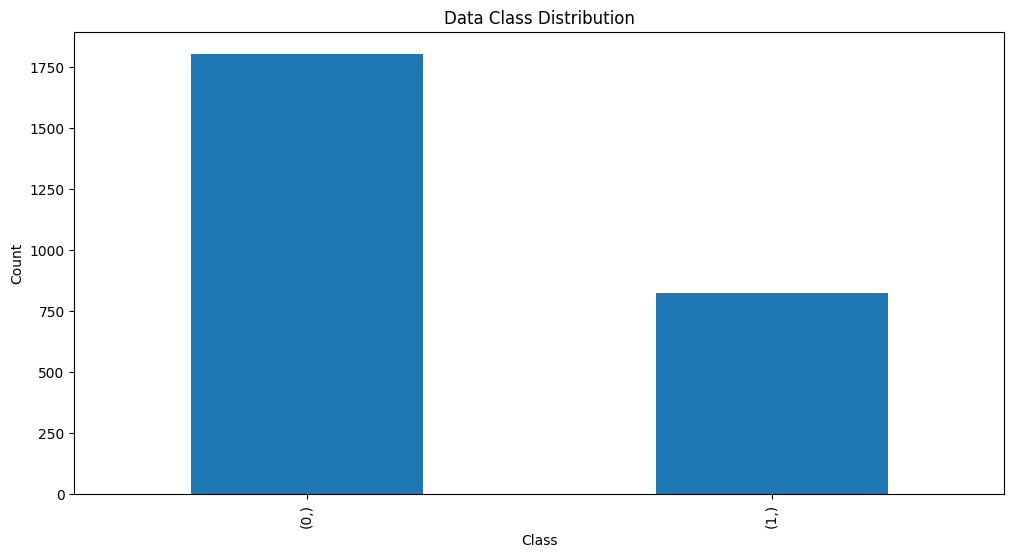

In [ ]:
plt.figure(figsize=(12, 6))
pd.DataFrame(labels).value_counts().plot(kind='bar')
plt.title('Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

num_samples, img_height, img_width, num_channels = images.shape
images_2d = images.reshape((num_samples, img_height * img_width * num_channels))

smote = SMOTE(sampling_strategy='auto', random_state=42)
images_resampled_2d, labels_resampled = smote.fit_resample(images_2d, labels)

images_resampled = images_resampled_2d.reshape((-1, img_height, img_width, num_channels))

images = images_resampled
labels = labels_resampled

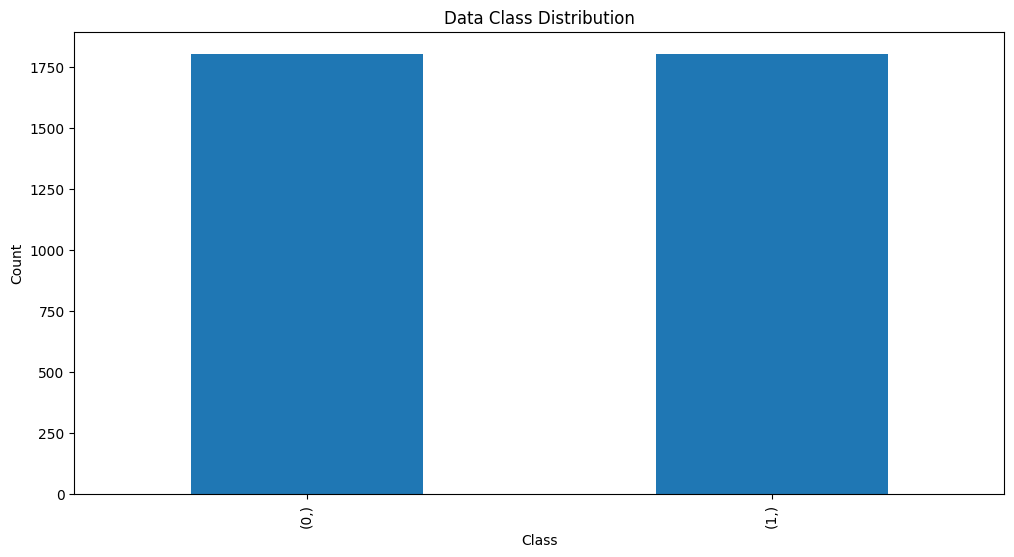

In [ ]:
plt.figure(figsize=(12, 6))
pd.DataFrame(labels).value_counts().plot(kind='bar')
plt.title('Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

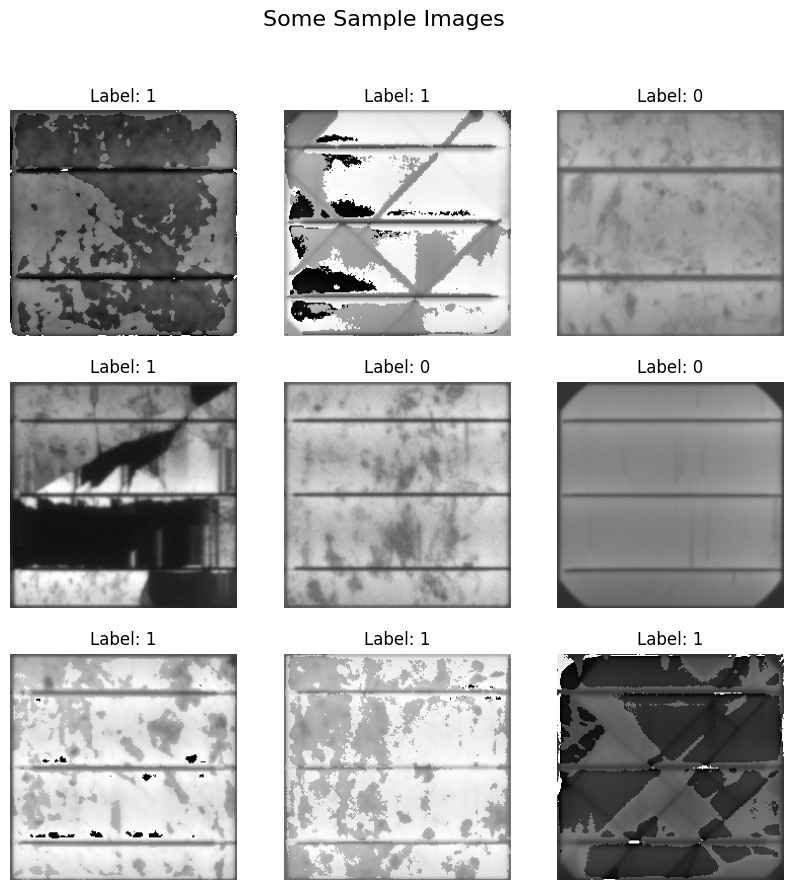

In [ ]:
sample_indices = np.random.choice(len(images), 9, replace=False)
plt.figure(figsize=(10, 10))
plt.suptitle("Some Sample Images", fontsize=16)

for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Label: {labels[idx]}")
    plt.axis('off')

plt.show()

In [ ]:
def image_preprocessing(img):
    img = img.astype('uint8')
    clahe = cv2.createCLAHE(tileGridSize=(8, 8))
    img = clahe.apply(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    img = np.expand_dims(img, 2)
    return np.repeat(img, 3, axis=2)

In [ ]:
# Apply the equalize function to each image in 'images'
enhanced_images = np.array([image_preprocessing(img) for img in images])

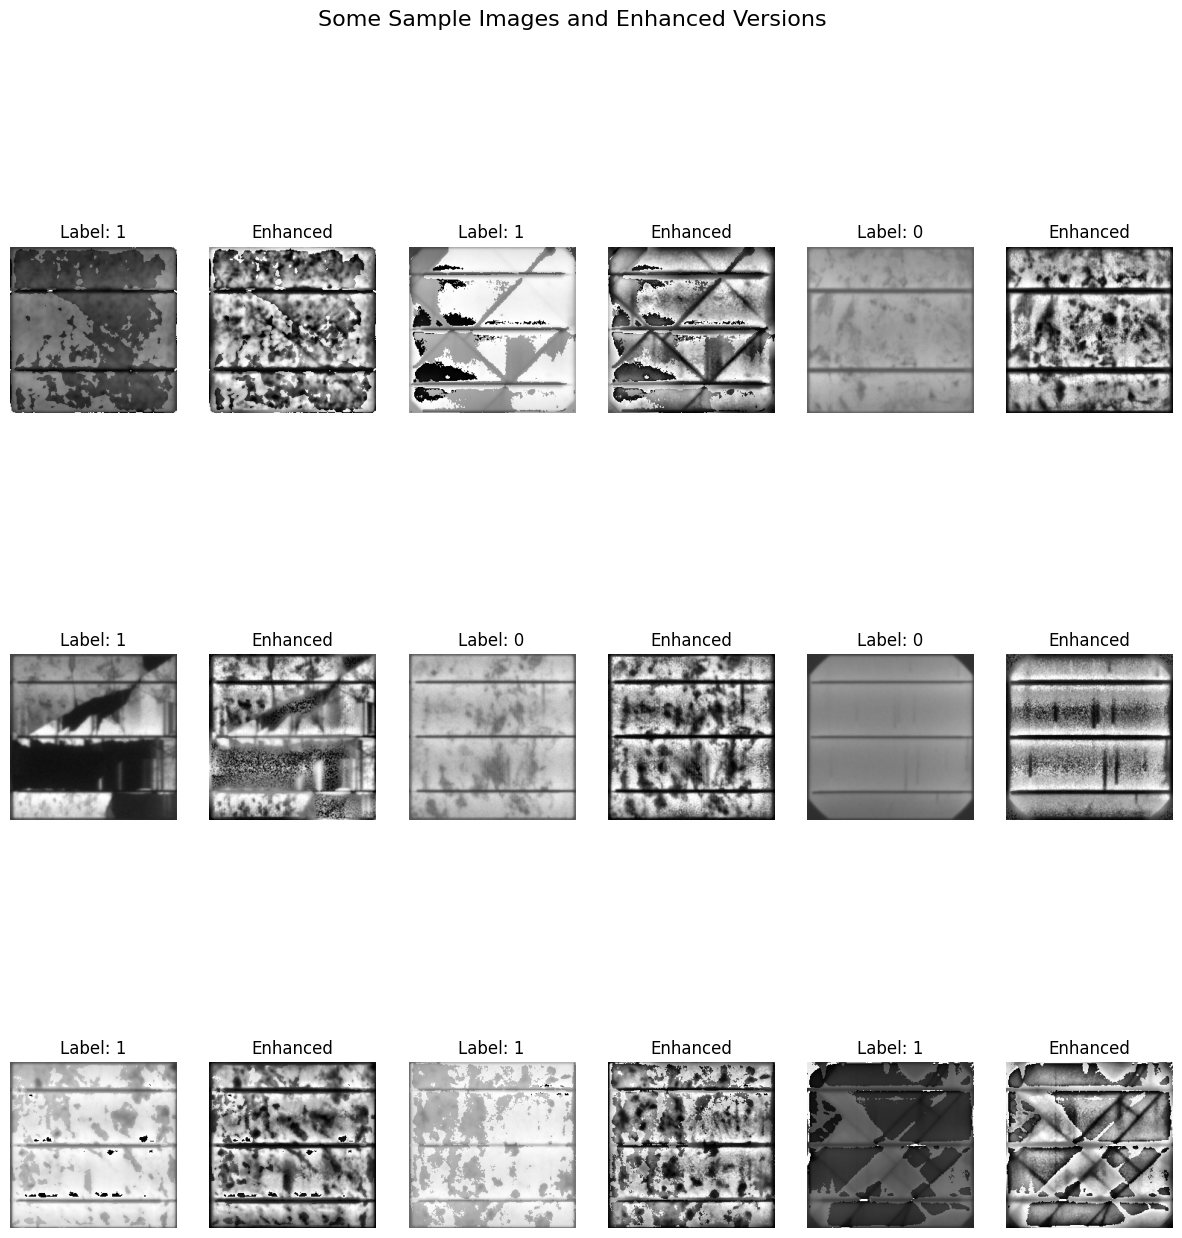

In [ ]:
# Display some sample images

# Create a 3x3 grid of subplots for plotting the images and their enhanced versions
plt.figure(figsize=(15, 15))
plt.suptitle("Some Sample Images and Enhanced Versions", fontsize=16)

for i, idx in enumerate(sample_indices):
    # Plot the original image
    plt.subplot(3, 6, 2 * i + 1)
    plt.imshow(images[idx])
    plt.title(f"Label: {labels[idx]}")
    plt.axis('off')

    # Plot the enhanced version beside the original image
    plt.subplot(3, 6, 2 * i + 2)
    plt.imshow(enhanced_images[idx])
    plt.title("Enhanced")
    plt.axis('off')

plt.show()

Training Images Shape: (2884, 224, 224, 3)
Training Labels Shape: (2884,)
Testing Images Shape: (722, 224, 224, 3)
Testing Labels Shape: (722,)


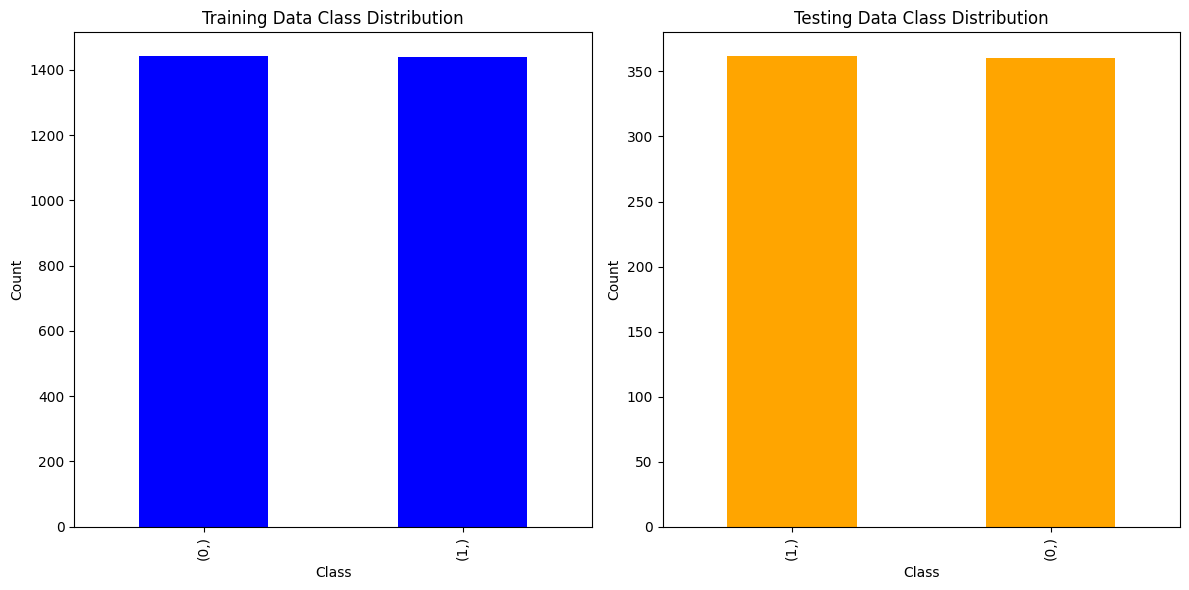

In [ ]:
from sklearn.model_selection import train_test_split

# Define the test size and random state for reproducibility
TEST_SIZE = 0.2  # 20% of the data for testing
RANDOM_STATE = 42

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    enhanced_images, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Print the shapes of the splits to verify
print(f"Training Images Shape: {train_images.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Testing Images Shape: {test_images.shape}")
print(f"Testing Labels Shape: {test_labels.shape}")

# Visualize the class distribution in the training and testing sets
plt.figure(figsize=(12, 6))

# Training set distribution
plt.subplot(1, 2, 1)
pd.DataFrame(train_labels).value_counts().plot(kind='bar', color='blue')
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Testing set distribution
plt.subplot(1, 2, 2)
pd.DataFrame(test_labels).value_counts().plot(kind='bar', color='orange')
plt.title('Testing Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# batch_size = 32

# datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     brightness_range=[0.5, 1.5],
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest',
# )

# # Apply data augmentation to train data
# train_datagen = datagen.flow(train_images, train_labels, batch_size=batch_size)

# data_augmentation = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")


data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical")
])


In [ ]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer='l2', name='feat')(x)  # Named 'feat' for feature extraction
x = layers.Dense(1, activation='sigmoid')(x)

In [ ]:
from tensorflow.keras.models import Model
model = Model(inputs, x)

In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Define the number of epochs
num_epochs = 100
batch_size = 16

# Start training the model
history = model.fit(
    train_images,
    train_labels,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.8006 - loss: 7.1395 - val_accuracy: 0.8532 - val_loss: 2.6505
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8950 - loss: 2.2848 - val_accuracy: 0.8463 - val_loss: 1.7911
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8852 - loss: 1.5579 - val_accuracy: 0.8740 - val_loss: 1.2524
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9092 - loss: 1.1198 - val_accuracy: 0.8740 - val_loss: 1.0129
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9063 - loss: 0.9138 - val_accuracy: 0.8989 - val_loss: 0.7967
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9340 - loss: 0.7074 - val_accuracy: 0.8809 - val_loss: 0.7343
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9263 - loss: 0.6202 - val_accuracy: 0.8767 - val_loss: 0.6764
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9345 - loss: 0.5169

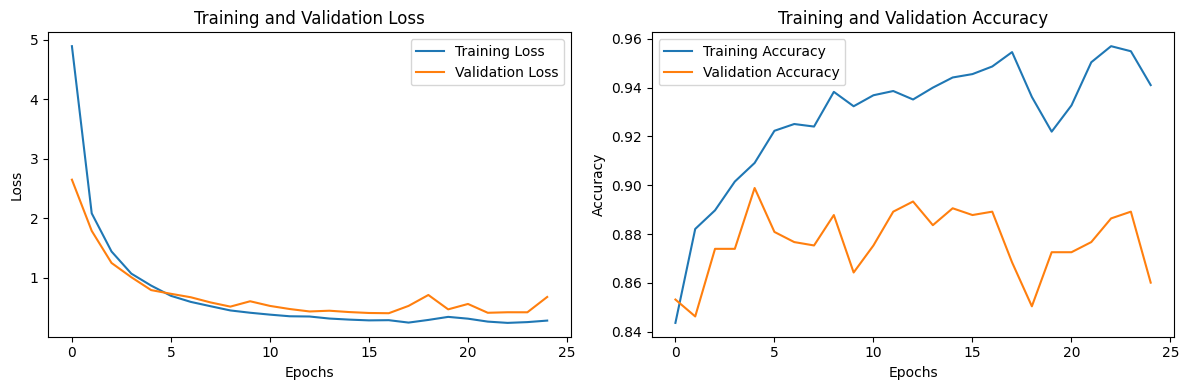

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Loss: {test_loss:.5f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.79671
Test Accuracy: 89.89%


In [ ]:
predictions = model.predict(test_images)
pred_labels = (predictions > 0.5).astype(int).flatten()

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step


              precision    recall  f1-score   support

           0       0.87      0.94      0.90       360
           1       0.94      0.86      0.89       362

    accuracy                           0.90       722
   macro avg       0.90      0.90      0.90       722
weighted avg       0.90      0.90      0.90       722



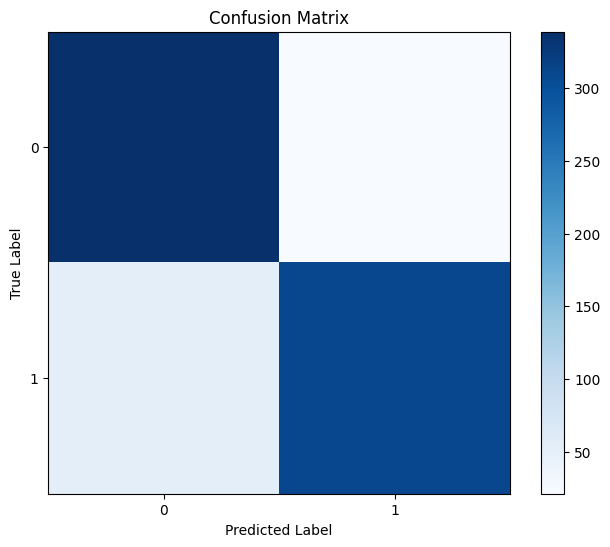

In [ ]:
print(classification_report(test_labels, pred_labels))

conf_matrix = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(test_labels)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
model_feat = Model(inputs=model.input, outputs=model.get_layer('feat').output)
feat_train = model_feat.predict(train_images)
feat_val = model_feat.predict(test_images)

print(feat_train.shape)  # Shape of the feature set
print(feat_val.shape)

91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step
(2884, 512)
(722, 512)


In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(feat_train, train_labels)
print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(feat_val, test_labels)

0.8988919667590027

In [ ]:
from sklearn.metrics import classification_report
y_pred = svm.predict(feat_val)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       360
           1       0.94      0.86      0.89       362

    accuracy                           0.90       722
   macro avg       0.90      0.90      0.90       722
weighted avg       0.90      0.90      0.90       722



In [ ]:
# Concatenate the feature vectors for SVM training
X_cnn = np.concatenate([feat_train, feat_val])
y = np.concatenate([train_labels, test_labels])

# Apply LDA with two components (for binary classification n_components=1)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit(X_cnn, y).transform(X_cnn)

# Train-test split for LDA-transformed data
from sklearn.model_selection import train_test_split
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size=0.2, random_state=42)

# Train SVM on LDA-reduced features
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(X_train_lda, y_train_lda)
print('SVM fitting done (with LDA)!!!')

SVM fitting done (with LDA)!!!


In [ ]:
svm_test_acc = svm.score(X_test_lda, y_test_lda)
print(f"SVM Test Accuracy (with LDA): {svm_test_acc * 90:.2f}%")

SVM Test Accuracy (with LDA): 83.89%


Classification Report (LDA + SVM):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       377
           1       0.95      0.90      0.93       345

    accuracy                           0.93       722
   macro avg       0.93      0.93      0.93       722
weighted avg       0.93      0.93      0.93       722



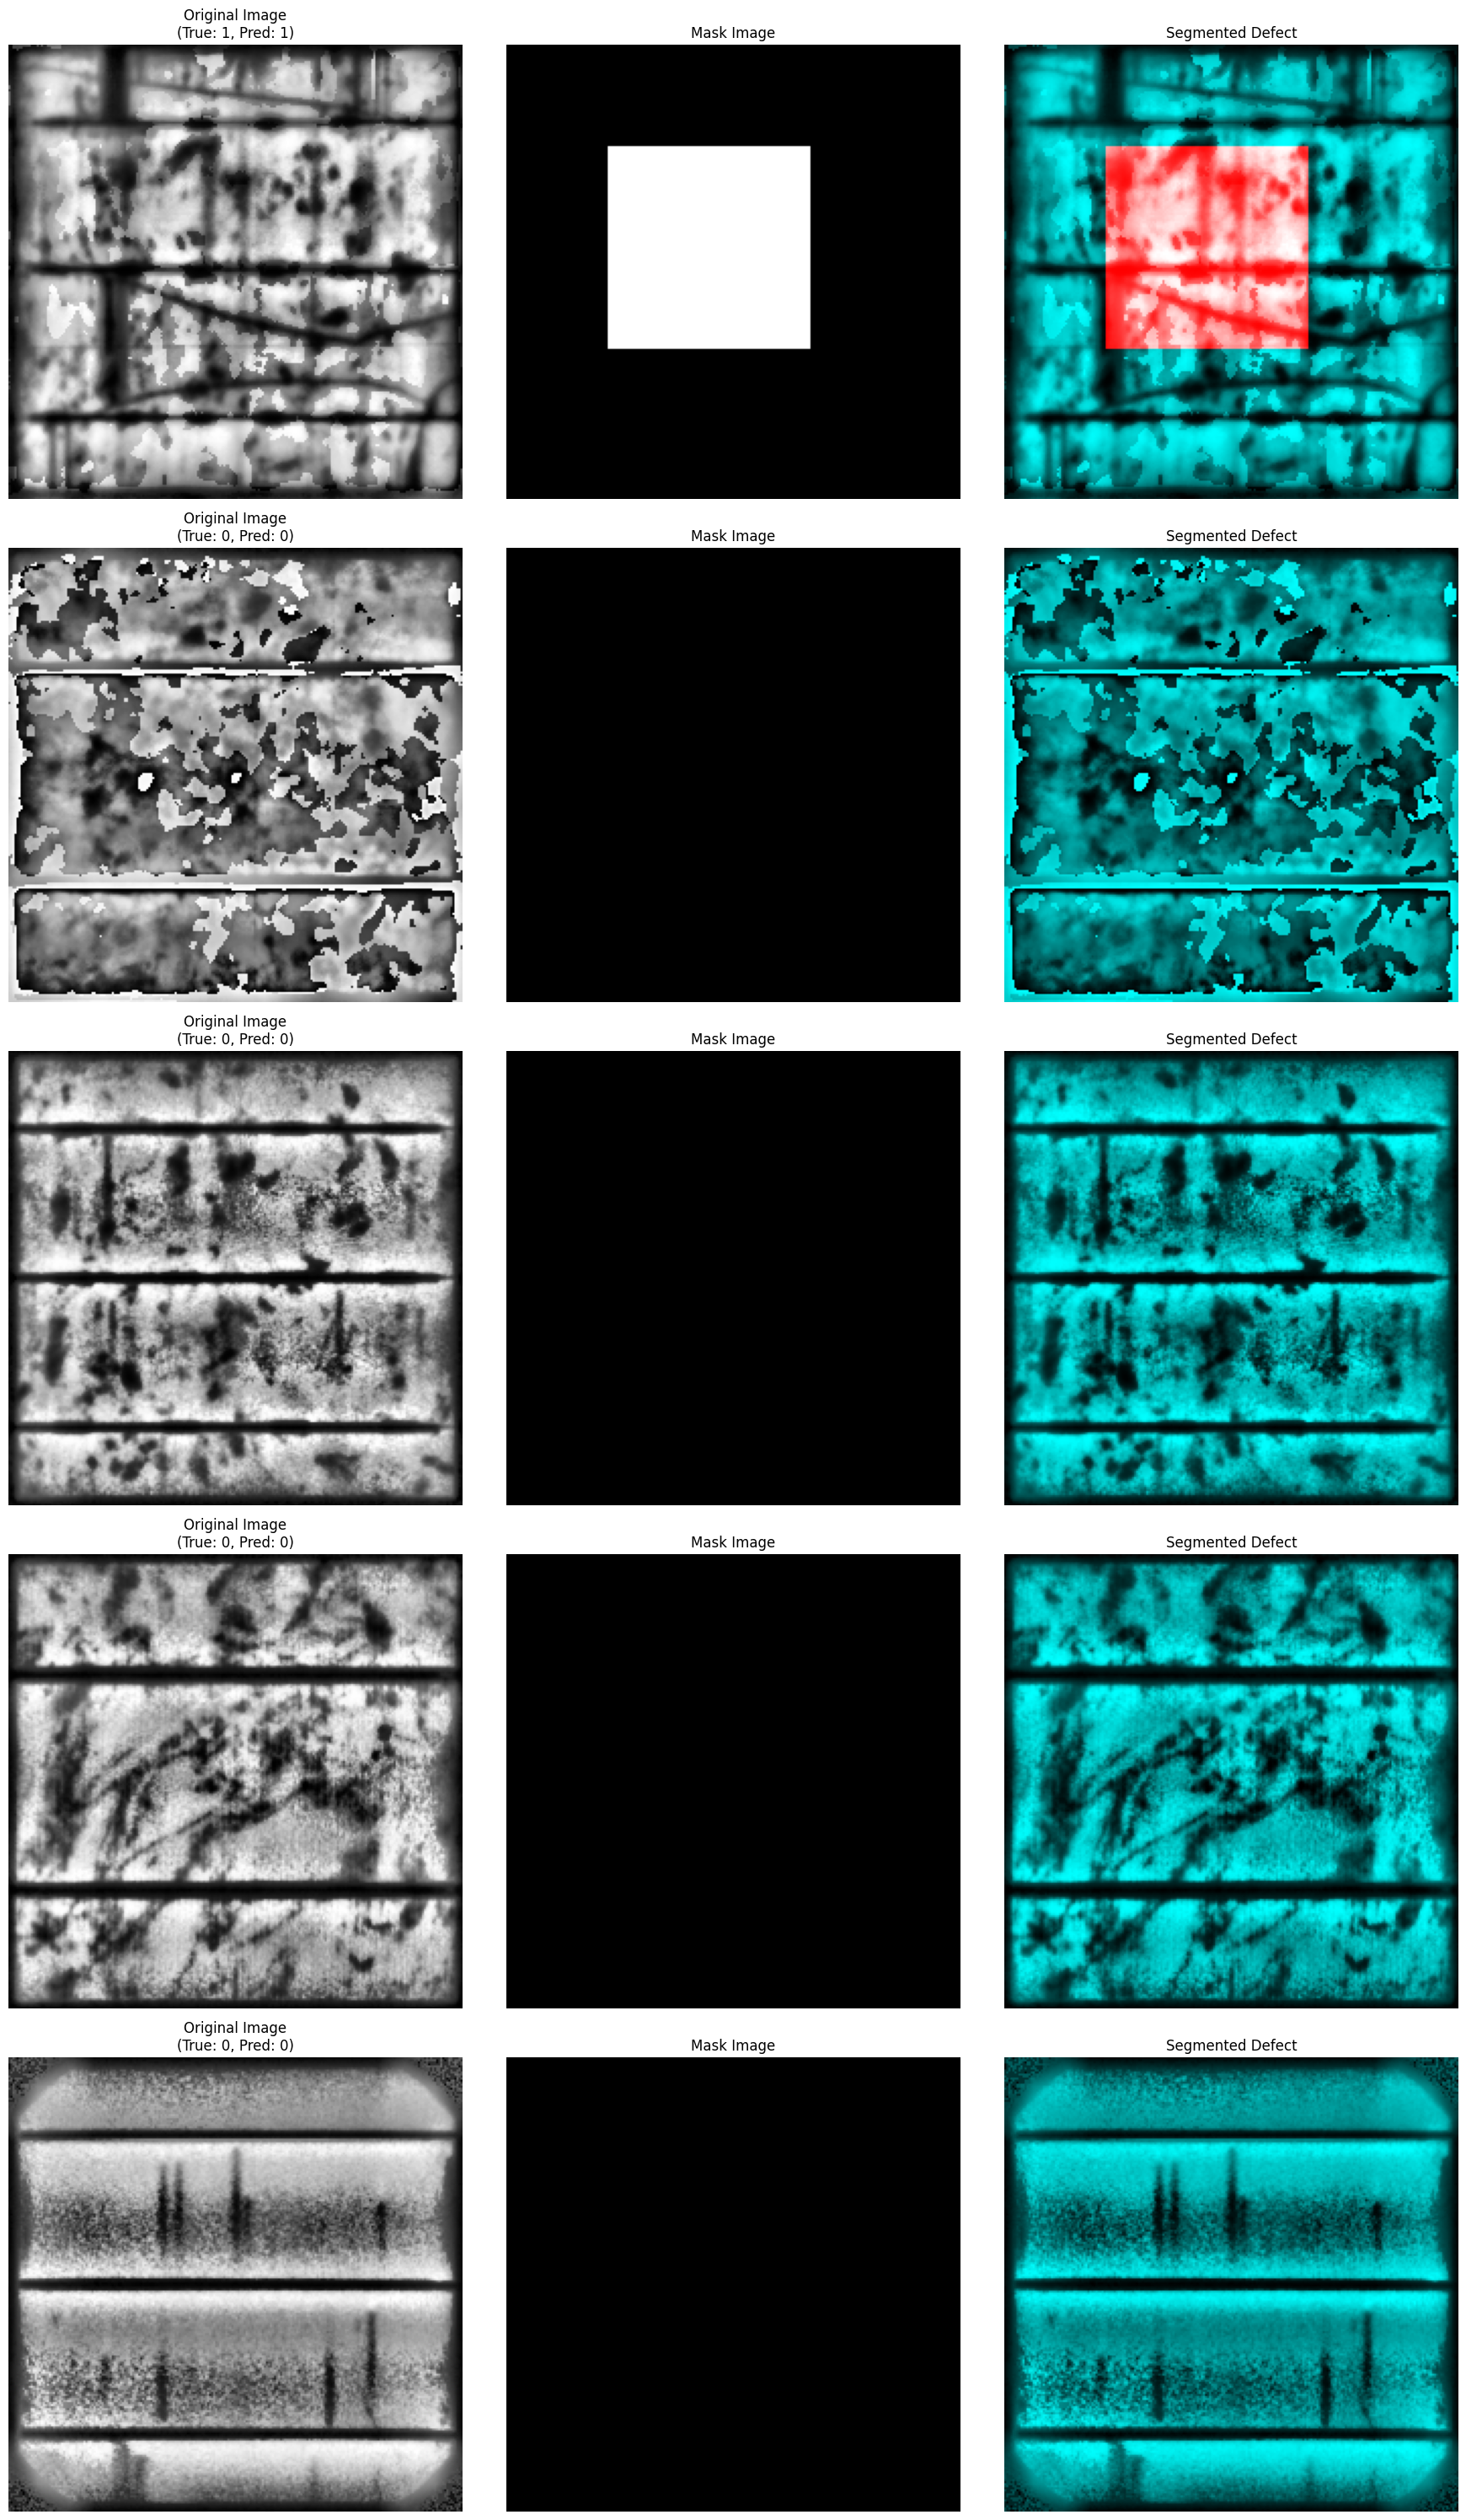

In [ ]:
#Code for segmenting the defect and finding where the defect is detected
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Ensure correct LDA-transformed features are used for prediction
y_pred_lda = svm.predict(X_test_lda)

# Print classification report
print("Classification Report (LDA + SVM):")
print(classification_report(y_test_lda, y_pred_lda))

# Example function to generate and display segmented defect images
def visualize_segmentation(test_images, y_pred, y_true, indices_to_visualize):
    """
    Function to visualize original images, defect masks, and segmented images.

    Args:
    - test_images: Array of test images (original).
    - y_pred: Predicted labels from SVM (binary: 0 = No Defect, 1 = Defect).
    - y_true: True labels for the test images.
    - indices_to_visualize: List of indices for images to visualize.

    Returns:
    - Displays a figure with original, mask, and segmented defect.
    """
    plt.figure(figsize=(18, len(indices_to_visualize) * 6))

    for i, idx in enumerate(indices_to_visualize):
        # Extract the original image
        original_img = test_images[idx]

        # Create a "defect mask" (for visualization purposes, based on prediction)
        defect_mask = np.zeros_like(original_img[:, :, 0])  # Initialize a blank mask
        if y_pred[idx] == 1:  # If a defect is predicted
            defect_mask[50:150, 50:150] = 255  # Example mask (adjust as per your defect area logic)

        # Combine the mask with the original image to simulate segmentation
        segmented_img = np.copy(original_img)
        segmented_img[:, :, 0] = defect_mask  # Overlay the mask on the red channel for visualization

        # Display images
        plt.subplot(len(indices_to_visualize), 3, 3 * i + 1)
        plt.imshow(original_img)
        plt.title(f"Original Image\n(True: {y_true[idx]}, Pred: {y_pred[idx]})")
        plt.axis("off")

        plt.subplot(len(indices_to_visualize), 3, 3 * i + 2)
        plt.imshow(defect_mask, cmap="gray")
        plt.title("Mask Image")
        plt.axis("off")

        plt.subplot(len(indices_to_visualize), 3, 3 * i + 3)
        plt.imshow(segmented_img)
        plt.title("Segmented Defect")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Select random indices from the test set for visualization
indices_to_visualize = np.random.choice(range(len(test_images)), 5, replace=False)

# Call the visualization function
visualize_segmentation(test_images, y_pred_lda, y_test_lda, indices_to_visualize)


In [ ]:
from sklearn.metrics import classification_report
y_pred_lda = svm.predict(X_test_lda)
print(classification_report(y_test_lda, y_pred_lda))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       377
           1       0.95      0.90      0.93       345

    accuracy                           0.93       722
   macro avg       0.93      0.93      0.93       722
weighted avg       0.93      0.93      0.93       722

